Pip Install Commands

In [1]:
%pip install shapely
%pip install node2vec


[notice] A new release of pip available: 22.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.




[notice] A new release of pip available: 22.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Libraries

In [2]:
import os
import json
import requests
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from shapely.prepared import prep
from shapely.geometry import mapping, shape, Point
from sklearn.neighbors import NearestNeighbors
from node2vec import Node2Vec
from sklearn.cluster import KMeans

w:\Program Files\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Const Values

In [3]:
YEAR_COLUMN = "year"
TEMPO_COLUMN = "tempo"
LOUDNESS_COLUMN = "loudness"
DURATION_COLUMN = "duration"
SONG_HOTTTNESSS_COLUMN = "song_hotttnesss"
ARTIST_HOTTTNESSS_COLUMN = "artist_hotttnesss"
ARTIST_FAMILIARITY_COLUMN = "artist_familiarity"
DECADE_COLUMN = "decade"

NUMERIC_COLUMNS_LIST = [
    YEAR_COLUMN,
    TEMPO_COLUMN,
    LOUDNESS_COLUMN,
    DURATION_COLUMN,
    SONG_HOTTTNESSS_COLUMN,
    ARTIST_HOTTTNESSS_COLUMN,
    ARTIST_FAMILIARITY_COLUMN,
    DECADE_COLUMN
]

SONG_TITLE_COLUMN = "song_title"
COUNTRY_COLUMN = "country"
ARTIST_LONGITUDE_COLUMN = "artist_longitude"
ARTIST_LATITUDE_COLUMN = "artist_latitude"
ARTIST_LOCATION_COLUMN = "artist_location"
ARTIST_ID_COLUMN = "artist_id"
SONG_ID_COLUMN = "song_id"

UNKNOWN_COUNTRY_VALUE = "unknown"
MUSIC_DATA_FOLDER_PATH = "../Music Data/"
MODELS_FOLDER_PATH = "../models/"

In [4]:
def get_attribute_node_name(node_type, node_value):
    return f"{node_type} {node_value}"

Loading Songs & Artists datasets

In [5]:
raw_songs_dataset = pd.read_csv("../Data/songs_dataset.csv")
raw_artists_dataset = pd.read_csv("../Data/artist_terms.csv")

Riaz: Merging datasets based on artist_id<br>
In the following cell i am removing the duplicate rows based on `artist_id` and only keep the first record

In [6]:
# Remove duplicates from the artist dataset based on artist_id
raw_artists_dataset = raw_artists_dataset.drop_duplicates(subset=ARTIST_ID_COLUMN, keep='first')

# Merge the datasets on artist_id
raw_music_dataset = pd.merge(raw_songs_dataset, raw_artists_dataset, on=ARTIST_ID_COLUMN, how='left')

In the above cell i merged the datasets based on artist_id and merge was on left join:
When you specify how='left', it means that all the keys from the left dataframe (in this case, the raw_songs_dataset dataframe) will be included in the merged dataframe, and only the matching keys from the right dataframe (in this case, the artist_dataset dataframe) will be added.

In other words:

All rows from the left dataframe (raw_songs_dataset) are retained.
If there are matching keys (in this case, artist_id) in the right dataframe (artist_dataset), the corresponding data from the right dataframe will be added to the merged dataframe.
If there are no matching keys in the right dataframe, the corresponding columns in the merged dataframe will be filled with NaN (missing values).

In [7]:
raw_music_dataset.head()

,song_id,song_title,year,release,tempo,loudness,duration,song_hotttnesss,artist_id,artist_name,artist_latitude,artist_longitude,artist_location,artist_hotttnesss,artist_familiarity,term
0,SOVFVAK12A8C1350D9,Tanssi vaan,1995.0,Karkuteillä,150.778,-10.555,156.55138,0.299877,ARMVN3U1187FB3A1EB,Karkkiautomaatti,NaN,NaN,NaN,0.356992,0.439604,pop rock
1,SOGTUKN12AB017F4F1,No One Could Ever,2006.0,Butter,177.768,-2.060,138.97098,0.617871,ARGEKB01187FB50750,Hudson Mohawke,55.8578,-4.24251,"Glasgow, Scotland",0.437504,0.643681,broken beat
2,SOBNYVR12A8C13558C,Si Vos Querés,2003.0,De Culo,87.433,-4.654,145.05751,NaN,ARNWYLR1187B9B2F9C,Yerba Brava,NaN,NaN,NaN,0.372349,0.448501,cumbia
3,SOHSBXH12A8C13B0DF,Tangle Of Aspens,NaN,Rene Ablaze Presents Winter Sessions,140.035,-7.806,514.29832,NaN,AREQDTE1269FB37231,Der Mystic,NaN,NaN,NaN,0.000000,0.000000,hard trance
4,SOZVAPQ12A8C13B63C,"Symphony No. 1 G minor ""Sinfonie Serieuse""/All...",NaN,Berwald: Symphonies Nos. 1/2/3/4,90.689,-21.420,816.53506,NaN,AR2NS5Y1187FB5879D,David Montgomery,NaN,NaN,NaN,0.109626,0.361287,ragtime


In [8]:
raw_music_dataset.isna().sum()

song_id                    0
song_title                 2
year                  484270
release                    7
tempo                      0
loudness                   0
duration                   0
song_hotttnesss       417782
artist_id                  0
artist_name                0
artist_latitude       641766
artist_longitude      641766
artist_location       487546
artist_hotttnesss         12
artist_familiarity       185
term                    3767
dtype: int64

In [9]:
raw_music_dataset.isna().sum().sum()

2677103

Shartil: For now I am going to delete all rows with missing data.

In [10]:
music_dataset = raw_music_dataset.dropna()

In [11]:
len(music_dataset)

126903

Shartil: Evenly selecing over 1000 songs, and saving them as the final dataframe

In [12]:
print(music_dataset.shape)

music_dataset = music_dataset.iloc[::120] # returns dataframe with (1058, 13)

print(music_dataset.shape)

(126903, 16)
(1058, 16)


Najeeb: Introducing a new column "country" based on Latitude and Longitude.

This code is used to load geographical data from a Local GeoJSON file, process it, and subsequently determine which country a given set of Latitudes and Logitudes coordinates falls into. The country names extracted from GeoJSON file are then inserted into a new column in a dataset.

- The "json.load" function reads the file and convert it into a Python dictionary ('geojson_data').

- An Empty dictionary named 'countries' is initiated to store the coordinated data associated with each country.

- The script iterates over each feature in the 'features' array of the 'geojson_data'. Each features represents a country.

- For each feature, the geometry ('geom') and the administrative name of the country is extracted.

- The geometry is then processed with a function 'prep' applied to 'shape(geom)'. This likely involves creating a geometric shape from the geometry data and preparing it for fast spatial queries. The processed geometry is dtored in the 'countries' dictionary with the country name as key.

- A function 'get_country' is defined which takes longitudes ('lon') and latitude ('lat') as arguments and creates a ('Point') object from coordinates.

- It then iterates  over the 'countries' dictionary and check whether the point is contained within any of the country geometrics using the 'contains' method of the geometry.

- if a containing country is found, the function returns the country's name. if no containing country is found, it returns a value 'UNKNOWN_COUNTRY_VALUE'

- A new column in the dataset ('msic_dataset') is populated by applying 'get_country' function to each row. In this way the country column is added to music_dataset based on latitude and logitude columns.


In [13]:
# Fetch and process the geojson data from a local file
with open(r'../Data/countries.geojson.json', 'r') as file:
    geojson_data = json.load(file)

countries = {}
for feature in geojson_data["features"]:
    geom = feature["geometry"]
    country = feature["properties"]["ADMIN"]
    countries[country] = prep(shape(geom))

# Function to get country name from latitude and longitude
def get_country(lon, lat):
    point = Point(lon, lat)
    for country, geom in countries.items():
        if geom.contains(point):
            return country

    return UNKNOWN_COUNTRY_VALUE

# Apply the function to create a new 'country' column
music_dataset[COUNTRY_COLUMN] = music_dataset.apply(
    lambda row: get_country(row[ARTIST_LONGITUDE_COLUMN], 
    row[ARTIST_LATITUDE_COLUMN]), 
    axis=1
    )

Shartil: Deleting redundant columns 

In [14]:
music_dataset = music_dataset.drop(
    [
        ARTIST_LATITUDE_COLUMN,
        ARTIST_LONGITUDE_COLUMN,
        ARTIST_LOCATION_COLUMN,
        SONG_ID_COLUMN,
        ARTIST_ID_COLUMN
    ], 
    axis=1)

Shartil: Deleting all rows with "unknown" as the country value and converting year values to int

In [15]:
music_dataset = music_dataset[music_dataset[COUNTRY_COLUMN] != UNKNOWN_COUNTRY_VALUE]

In [16]:
music_dataset[YEAR_COLUMN] = music_dataset[YEAR_COLUMN].astype(int)

In [17]:
music_dataset.reset_index(drop=True, inplace=True)
music_dataset.head()

,song_title,year,release,tempo,loudness,duration,song_hotttnesss,artist_name,artist_hotttnesss,artist_familiarity,term,country
0,No One Could Ever,2006,Butter,177.768,-2.060,138.97098,0.617871,Hudson Mohawke,0.437504,0.643681,broken beat,United Kingdom
1,Don't Save It All For Christmas Day,2004,Merry Christmas With Love,127.397,-9.149,273.08363,0.732281,Clay Aiken,0.500596,0.852100,teen pop,United States of America
2,White Lies,2006,Rocinate,92.103,-9.323,388.80608,0.417314,Ester Drang,0.330889,0.525616,shoegaze,United States of America
3,Guess Who I Saw In Paris,1999,Sugar Me,105.054,-18.484,170.31791,0.368414,Claudine Longet,0.377489,0.563184,easy listening,France
4,No More Birthdays (Phil Spector Folk) / San Fr...,2006,Born To Please,95.658,-6.141,280.45016,0.000000,Sound Team,0.368423,0.590111,art rock,United States of America


In [18]:
music_dataset.shape

(1035, 12)

Shartil: making sure the final dataset contains 1000 songs

In [19]:
music_dataset = music_dataset.iloc[:1000] # returns dataframe with 1000 songs

print(music_dataset.shape)

(1000, 12)


Shartil: Adding decade column to dataset

In [20]:
music_dataset = music_dataset.assign(decade=lambda row: (row[YEAR_COLUMN].astype(int) // 10) * 10)
music_dataset.head()

,song_title,year,release,tempo,loudness,duration,song_hotttnesss,artist_name,artist_hotttnesss,artist_familiarity,term,country,decade
0,No One Could Ever,2006,Butter,177.768,-2.060,138.97098,0.617871,Hudson Mohawke,0.437504,0.643681,broken beat,United Kingdom,2000
1,Don't Save It All For Christmas Day,2004,Merry Christmas With Love,127.397,-9.149,273.08363,0.732281,Clay Aiken,0.500596,0.852100,teen pop,United States of America,2000
2,White Lies,2006,Rocinate,92.103,-9.323,388.80608,0.417314,Ester Drang,0.330889,0.525616,shoegaze,United States of America,2000
3,Guess Who I Saw In Paris,1999,Sugar Me,105.054,-18.484,170.31791,0.368414,Claudine Longet,0.377489,0.563184,easy listening,France,1990
4,No More Birthdays (Phil Spector Folk) / San Fr...,2006,Born To Please,95.658,-6.141,280.45016,0.000000,Sound Team,0.368423,0.590111,art rock,United States of America,2000


In [21]:
min_decade = music_dataset[DECADE_COLUMN].min()
max_decade = music_dataset[DECADE_COLUMN].max()
decade_array = np.arange(min_decade, max_decade + 10, 10, dtype=int)

Shartil: Saving music_dataset as a CSV file

In [22]:
if not os.path.isdir(MUSIC_DATA_FOLDER_PATH):
    os.mkdir(MUSIC_DATA_FOLDER_PATH)

music_dataset.to_csv(f"{MUSIC_DATA_FOLDER_PATH}/music_dataset.csv", mode='w+')

Shartil: I will normalize the numeric columns using min max normalization.

In [23]:
def min_max_normalize_column(df, column_name):
    min_val = df[column_name].min()
    max_val = df[column_name].max()
    
    if min_val == max_val:
        raise ValueError("Cannot normalize column when all values are the same.")
    
    df[column_name] = (df[column_name] - min_val) / (max_val - min_val)

In [24]:
normalized_music_dataset = music_dataset.copy()

for numeric_column in NUMERIC_COLUMNS_LIST:
    min_max_normalize_column(normalized_music_dataset, numeric_column)

In [25]:
normalized_music_dataset.head()

,song_title,year,release,tempo,loudness,duration,song_hotttnesss,artist_name,artist_hotttnesss,artist_familiarity,term,country,decade
0,No One Could Ever,0.925926,Butter,0.694103,0.999149,0.076051,0.686709,Hudson Mohawke,0.532471,0.612163,broken beat,United Kingdom,0.833333
1,Don't Save It All For Christmas Day,0.888889,Merry Christmas With Love,0.455336,0.804487,0.164387,0.813866,Clay Aiken,0.609258,0.889696,teen pop,United States of America,0.833333
2,White Lies,0.925926,Rocinate,0.288036,0.799709,0.240610,0.463807,Ester Drang,0.402714,0.454948,shoegaze,United States of America,0.833333
3,Guess Who I Saw In Paris,0.796296,Sugar Me,0.349426,0.548151,0.096698,0.409459,Claudine Longet,0.459429,0.504973,easy listening,France,0.666667
4,No More Birthdays (Phil Spector Folk) / San Fr...,0.925926,Born To Please,0.304888,0.887086,0.169239,0.000000,Sound Team,0.448395,0.540830,art rock,United States of America,0.833333


Shartil: Now I am going to create the graph

In [26]:
music_graph = nx.Graph()

In [27]:
for current_index, current_row in normalized_music_dataset.iterrows():
    node_data_dict = {}

    for current_column in NUMERIC_COLUMNS_LIST:
        node_data_dict[current_column] = current_row[current_column]

    music_graph.add_node(str(current_index), **node_data_dict)

In [28]:
# Shartil: adding empty nodes for the decades, which function as main nodes
# i.e., all the songs from 1950 will be connected to the 1950 node.
# This will save complex logic of connecting all the songs from the decade, and ensuring that the resulted graph will be less complicated.
for current_decade in decade_array:
    node_name = get_attribute_node_name(DECADE_COLUMN, current_decade)
    music_graph.add_node(node_name)

Shartil: for now, the graph only has decade nodes & song nodes that contain their matching ID in the dataframe

In [29]:
for index, row in music_dataset.iterrows():
    current_decade = row[DECADE_COLUMN]
    node_name = get_attribute_node_name(DECADE_COLUMN, current_decade)
    music_graph.add_edge(node_name, str(index))

print(music_graph)

Graph with 1007 nodes and 1000 edges


Shartil: Plotting knowledge graph using code shown in notebook 8

w:\Program Files\Python310\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


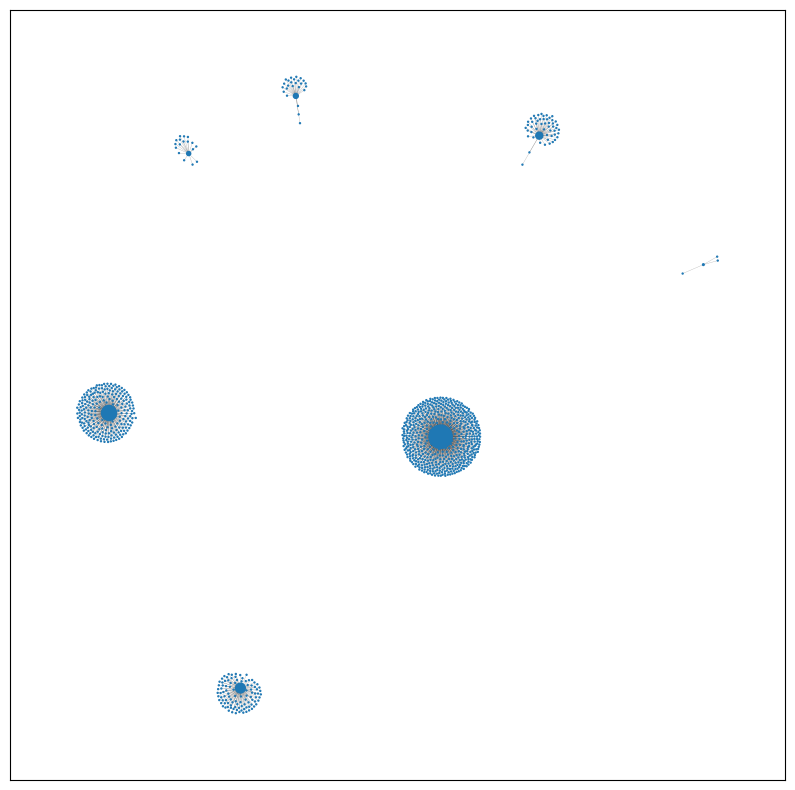

In [30]:
# use spring layout
pos = nx.spring_layout(music_graph)

# compute degree centrality
# degree represents the number of edges from each node,
# the centrality allows us to undertsand the more 'popular' nodes
cent = nx.degree_centrality(music_graph)
cent_array = np.array(list(cent.values()))

# size of nodes will be proportional to their popularity
node_size = list(map(lambda x: x * 500, cent.values()))


plt.figure(figsize=(10, 10))

#draw nodes
nodes = nx.draw_networkx_nodes(music_graph, pos, node_size=node_size,
                               cmap=plt.cm.plasma,
                               nodelist=list(cent.keys()))
# draw edges
edges = nx.draw_networkx_edges(music_graph, pos, width=0.25, alpha=0.3)

plt.show()

Riaz: Node Embeding using node2vec

In [31]:
# Precompute probabilities and generate walks - **ON WINDOWS ONLY WORKS WITH workers=1**
node2vec = Node2Vec(music_graph, dimensions=64, walk_length=10, num_walks=100, workers=4)  # Use temp_folder for big graphs

# Embed nodes
model = node2vec.fit(window=10, min_count=1, batch_words=4)  # Any keywords acceptable by gensim.Word2Vec can be passed, `dimensions` and `workers` are automatically passed (from the Node2Vec constructor)

Computing transition probabilities: 100%|██████████| 1007/1007 [00:00<00:00, 1352.91it/s]


Saving embedding and model into models folder

In [32]:
# Save embeddings for later use
model.wv.save_word2vec_format(f"{MODELS_FOLDER_PATH}/embedding")

# Save model for later use
model.save(f"{MODELS_FOLDER_PATH}/node2vec_model")


Shartil: creating NearestNeighbors selector

In [33]:
nodes = list(music_graph.nodes())
embeddings = np.array([model.wv[str(node)] for node in nodes])
nearestNeighborSelector = NearestNeighbors(n_neighbors=6).fit(embeddings)

#### Function used for User input handling

In [34]:
def get_song_id(song_title):
    matching_songs = music_dataset[music_dataset[SONG_TITLE_COLUMN].str.lower().str.contains(song_title.lower())]
    if not matching_songs.empty:
        return matching_songs.iloc[0].name
    return None

In [35]:
def recommend_songs(query):
    user_song_title = query
    song_id = get_song_id(user_song_title)

    if song_id is not None:
        user_song_embed = model.wv[str(song_id)]
        distances, indices = nearestNeighborSelector.kneighbors([user_song_embed])
        print("Similar songs:")
        similar_songs_df = music_dataset.loc[indices[0]]
        display(similar_songs_df)
    else:
        print("Song not found in the dataset.")

In [36]:
def recommend_songs_by_query(query_type, query):
    filtered_music_df = music_dataset[music_dataset[query_type].astype(str).str.lower() == str(query).lower()]
    
    if len(filtered_music_df) > 0:
        chosen_song = filtered_music_df.sample(n=1)
        recommend_songs(chosen_song[SONG_TITLE_COLUMN].iloc[0])
    else:
        print("No songs found.")

#### User Interface

In [37]:
user_options_dict = {
    1 : ["song_title", "song title"],
    2 : ["artist_name", "artist name"],
    3 : ["decade", "decade"],
    4 : ["country", "country"],
    5 : ["term (genre)", "term"],
    6 : ["year", "year"]
}

In [38]:
try:
    print("Query by: song_title, artist_name, decade, country, term (genre) or year")
    input_text = "Enter your query type (provide number only):"

    for user_option_id, user_option in user_options_dict.items():
        input_text += f"\n{user_option_id} -> {user_option[0]}"

    user_query_input = int(input(input_text))
    query_type = user_options_dict[user_query_input][0]
    query = input(f"Enter value for the {user_options_dict[user_query_input][1]}")

    if query_type == 'song_title':
        recommend_songs(query)
    else:
        recommend_songs_by_query(query_type, query)
except ValueError as ex:
    print('Please provide valid input')

Query by: song_title, artist_name, decade, country, term (genre) or year
Similar songs:


,song_title,year,release,tempo,loudness,duration,song_hotttnesss,artist_name,artist_hotttnesss,artist_familiarity,term,country,decade
770,Teachers,1967,Songs of L. Cohen / Songs of love and hate / N...,101.936,-12.113,182.54322,0.662568,Leonard Cohen,0.564623,0.800189,folk rock,United States of America,1960
292,My Heart Belongs To Only You,1964,The Best Of Bobby Vinton,108.132,-11.061,164.04853,0.594483,Bobby Vinton,0.389242,0.614827,oldies,United States of America,1960
284,Key To The Highway,1968,Blue All The Way,120.829,-11.703,163.65669,0.265861,Tina Britt,0.000000,0.360614,chicago blues,United States of America,1960
167,Oddjob's Pressing Engagement (2003 Digital Rem...,1964,Goldfinger,124.321,-12.097,188.31628,0.287515,John Barry,0.419381,0.616638,easy listening,United Kingdom,1960
341,Magic Town,1966,Back to Back - The Vogues & The Equals,91.035,-12.414,180.81914,0.543365,The Vogues,0.411501,0.583415,brill building pop,United States of America,1960
501,I Want A Boy,1965,Featuring Veronica,127.229,-10.718,126.06649,0.434838,The Ronettes,0.533886,0.661506,brill building pop,United States of America,1960
